# Q: KOSPI가 어떤 종목때문에 오르고 내렸는가?

  * 어느날은 KOSPI지수가 오르고, 어떤날은 내린다.
  * 상승했다면 어떤 종목 때문이고, 하강했다면 어떤 종목 때문인가?

# Approach

  * 네이버 금융에서 종목별 시가총액 제공한다
  * html로 적당히 긁어오자
    * 단점은 현재 시점 시가총액만 제공한다. 과거 데이터는 안보인다.
    * 매일 한번씩 긁어와야 한다 TT
  * 현재-과거 시가총액을 종목별로 산출하고, 상승/하락한 크기(절대값)을 보자

In [2]:
%matplotlib inline

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
import datetime
import pickle
import os
import seaborn as sns
from matplotlib.font_manager import FontProperties
from IPython.display import display
import naver_kospi_api as nka

In [91]:
plt.style.use('seaborn-notebook')
#sns.set_style("whitegrid")
#sns.set_style("ticks")
sns.set_style("dark")

plt.rc('font', family='Noto Sans Korean')

# 데이터 정리

네이버 시가총액 데이터는 내림차순으로 정렬되어 출력되므로 날짜별로 종목의 row 가 바뀔 수 있다(종목별 시가총액이 바뀔 수 있다.)

In [93]:
df1=nka.load_naver_kospi_data('naver_kospi_volume_160721_200825.pickle')
df2=nka.load_naver_kospi_data('naver_kospi_volume_160726_011546.pickle')

# 종목명으로 정렬
df1.sort_values('종목명', inplace=True)
df2.sort_values('종목명', inplace=True)

# 종목명이 같은지 확인
dd=df2['종목명']==df1['종목명']
display(dd.describe())

count     1218
unique       1
top       True
freq      1218
Name: 종목명, dtype: object

# 시가총액

$$KOSPI = \frac{비교시점 시가총액}{기준시점(1980. 1. 4) 시가총액} \times 100$$

  * 기준시점 시가총액은 15조4000억원(http://biz.chosun.com/site/data/html_dir/2015/01/13/2015011304091.html)
  * 증자·신규상장 등으로 주식 수가 늘어난 부분을 보정하는 작업을 거치기 때문이다. 지수는 '주가'의 움직임을 보여주는 지표인데, 이 작업을 하지 않으면 시가총액의 상승이 주가의 상승 때문인지, 아니면 주식 수의 증가 때문인지 불명확해지는 왜곡 현상이 생긴다. 그래서 신규상장 등으로 분자(오늘의 시가총액)가 늘어나면 그만큼 분모(기준시점의 시가총액)도 똑같이 늘려주는 작업을 거쳐 지수를 산출한다.

## 시가총액 변동량

In [94]:
s1=df1['시가총액'].sum()
s2=df2['시가총액'].sum()

print '시가총액(Prev)  : %d' % s1
print '시가총액(Curr)  : %d' % s2
print '시가총액(Delta) : %d' % (s2-s1)
print '시가총액(Ratio) : %.6f' % (s2/s1)

# 시가총액 변동량
df_diff=df2['시가총액'] - df1['시가총액']
#df_dummy=pd.DataFrame([0]*len(df1), columns=['기여도'])

df_new=pd.concat([df1['종목명'], df_diff, df_diff], axis=1)
df_new.columns=['종목명', '시가총액변동금액', '기여도(%)']
df_ratio=df_new['기여도(%)'].apply(lambda x : x / s2 * 100)
df_new['기여도(%)']=df_ratio
display(df_new.head())
print df_ratio.sum()

시가총액(Prev)  : 13081507
시가총액(Curr)  : 13075095
시가총액(Delta) : -6412
시가총액(Ratio) : 0.999510


,종목명,시가총액변동금액,기여도(%)
0,삼성전자,-58618.0,-0.448318
1,한국전력,1926.0,0.014730
2,현대차,12116.0,0.092665
3,삼성전자우,-2251.0,-0.017216
4,삼성물산,2790.0,0.021338


-0.0490397966516


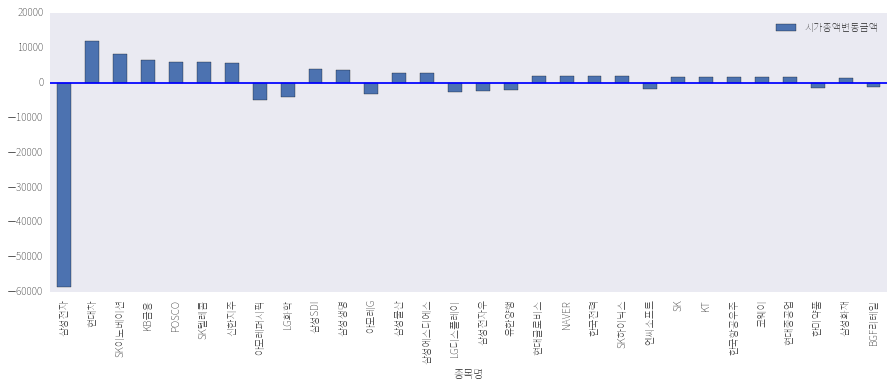

In [95]:
# 시가총액의 변동량이 큰 순서대로 정렬
df_new_sorted=df_new.reindex(df_new['시가총액변동금액'].abs().sort_values(ascending=False).index)

# 상위 n개만 출력
n=30
df_new_sorted[:n].plot(x='종목명', y='시가총액변동금액', kind='bar', figsize=(15, 5))
plt.axhline(0, color='b')

## 오른 금액, 내린 금액(억)

In [88]:
k='시가총액변동금액'
df_up=df_new[df_new[k] > 0]
df_down=df_new[df_new[k] < 0]
print '+%d, %d' % (df_up[k].sum(), df_down[k].sum())
print '%d' % (df_up[k].sum()+df_down[k].sum())

+40921, -18426
22495


## 누가 올랐나? 누가 내렸나? (T억이상)

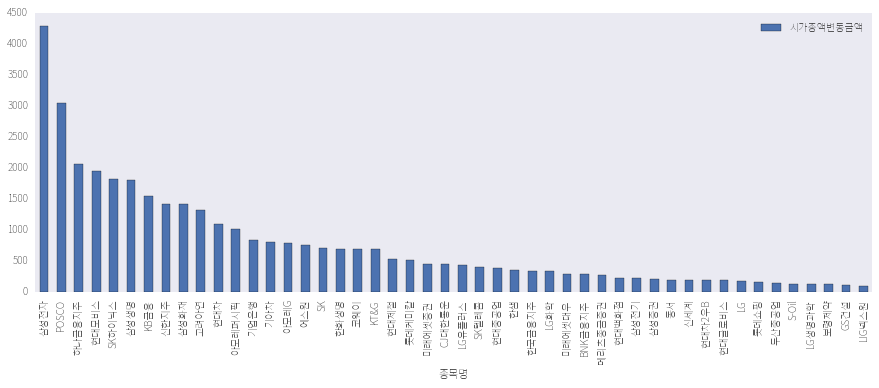

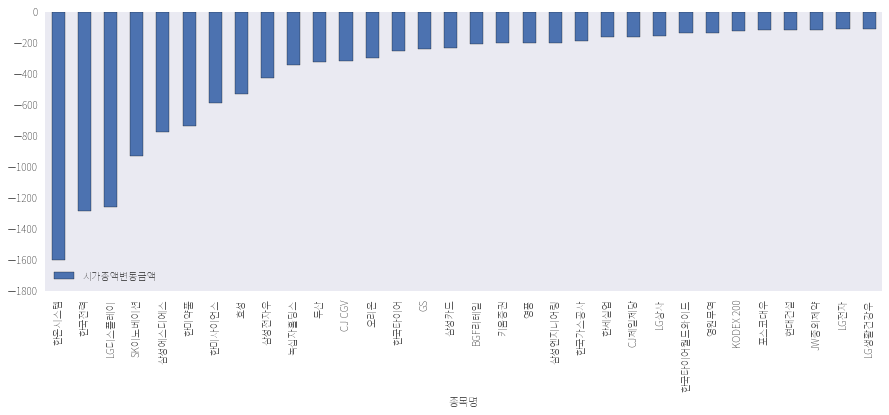

In [89]:
T=100

df_new_up=df_new[df_new[k] >= T].sort_values(k, ascending=False)
df_new_down=df_new[df_new[k] <= -T].sort_values(k, ascending=True)

df_new_up.plot(x='종목명', y='시가총액변동금액', kind='bar', figsize=(15, 5))
df_new_down.plot(x='종목명', y='시가총액변동금액', kind='bar', figsize=(15, 5))

# 시가총액 상위권과 kospi 가 상당히 밀접한 관계가 있다

  * KOSPI는 종목별 시가총액의 함수이므로 당연히 시가총액 비중이 높은 종목의 변동량과 관계가 있다.

327    KRX:005930
Name: googlecode, dtype: object
Series([], Name: googlecode, dtype: object)
Series([], Name: googlecode, dtype: object)
727    KRX:012330
Name: googlecode, dtype: object
Series([], Name: googlecode, dtype: object)
322    KRX:000830
Name: googlecode, dtype: object
87    KRX:000660
Name: googlecode, dtype: object
425    KRX:090430
Name: googlecode, dtype: object
62    KRX:035420
Name: googlecode, dtype: object
323    KRX:032830
Name: googlecode, dtype: object


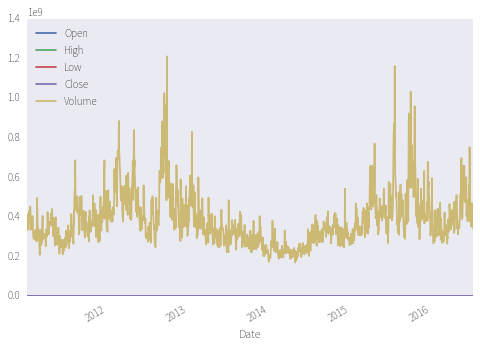

In [176]:
start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2016, 7, 11)

# 시가총액 상위 10개
df2_sorted=df2.sort_values('시가총액', ascending=False, inplace=False)
df2_sorted[:10]

# 종목코드 가져오자
fd=open('stock_codes.pickle')
df_stock_code=pickle.load(fd)
fd.close()

googlecode=[]
for name in df2_sorted['종목명'][:10]:
    df=df_stock_code[df_stock_code['name']==name]['googlecode']
    print df

df_list=[]
for gc in googlecode:
    print gc.iloc[0]
    #df_list.append(data.DataReader(gc.iloc[0], 'google', start, end))
df_kospi=data.DataReader('KRX:KOSPI', 'google', start, end)
df_king=pd.concat(df_list + [df_kospi], axis=1)

df_king.plot()

In [119]:
df_stock_code

,code,name,googlecode,type
0,095570,AJ네트웍스,KRX:095570,KOSPI
1,060310,3S,KOSDAQ:060310,KOSDAQ
2,194860,SY이노베이션,NaN,KONEX
3,068400,AJ렌터카,KRX:068400,KOSPI
4,006840,AK홀딩스,KRX:006840,KOSPI
5,027410,BGF리테일,KRX:027410,KOSPI
6,138930,BNK금융지주,KRX:138930,KOSPI
7,001460,BYC,KRX:001460,KOSPI
8,001040,CJ,KRX:001040,KOSPI
9,079160,CJ CGV,KRX:079160,KOSPI
